# General Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
games = pd.read_csv('/datasets/games.csv')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [2]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


We have one summary table for the games. It has 11 columns and 16715 rows. The columns are represented by two data types: float and object

# Data preparation

In [3]:
# Bringing all columns to lower case
games.columns = games.columns.str.lower()

In [4]:
# converting data into the right types
# converting float columns by cutting off the decimal places
pd.set_option('display.float_format', lambda x:
                        '%.0f' % x if (x == x and x*10 % 10 == 0) 
                  else ('%.1f' % x if (x == x and x*100 % 10 == 0)
                  else '%.2f' % x))

In the columns with the float data type, we "trimmed" the decimal places to one decimal place. 
For better perception of the column names, we have lowered them to lower case.

In [5]:
# pass processing
print(games.isna().sum())
# replace missing values in the name and genre columns with unknown
games['name'] = games['name'].fillna('unknown')
games['genre'] = games['genre'].fillna('unknown')


name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64


In [6]:
# check for duplicates
print(games.duplicated().value_counts())

False    16715
dtype: int64


In [7]:
#delete outlying lines
games = games.query('~(na_sales <= 0.01 and eu_sales <= 0.01 and jp_sales <= 0.01 and other_sales <= 0.01 and critic_score.isna() and user_score.isna())')

In [8]:
# processing tbd = "to be determined" 
games.query('user_score == "tbd"')
games['user_score'] = games['user_score'].replace('tbd','-1')

In [9]:
old_games = games.query('year_of_release <= 2000')
old_games_amount = old_games['name'].count()
old_games_without_score = old_games['critic_score'].isna().sum()
print('Количество игр, выпущенных до 2000 года:', old_games_amount)
print('Количество игр, выпущенных до 2000 года, не имеющие рейтинга:', old_games_without_score)
print('Отношение игр без рейтинга к общему количеству игр: {:.2f}'.format(old_games_without_score/old_games_amount))

Количество игр, выпущенных до 2000 года: 2287
Количество игр, выпущенных до 2000 года, не имеющие рейтинга: 2048
Отношение игр без рейтинга к общему количеству игр: 0.90


In [10]:
new_games = games.query('year_of_release >= 2000')
new_games_amount = new_games['name'].count()
new_games_without_score = new_games['critic_score'].isna().sum()
print('Количество игр, выпущенных после 2000 года:', new_games_amount)
print('Количество игр, выпущенных после 2000 года, не имеющие рейтинга:', new_games_without_score)
print('Отношение игр без рейтинга к общему количеству игр: {:.2f}'.format(new_games_without_score/new_games_amount))

Количество игр, выпущенных после 2000 года: 14017
Количество игр, выпущенных после 2000 года, не имеющие рейтинга: 6130
Отношение игр без рейтинга к общему количеству игр: 0.44


In [11]:
new_games_without_score = new_games.query('critic_score.isna()')
# print(new_games_without_score['critic_score'].shape)
grouped_games = new_games_without_score.groupby('platform').agg(amount = pd.NamedAgg(column = 'name', aggfunc = 'count'))
grouped_games.sort_values(by = 'amount', ascending = False)

,amount
platform,
DS,1334
PS2,787
Wii,689
PSP,654
PS3,479
GBA,360
3DS,326
X360,318
PSV,262


Initially, there are gaps in six columns. The name and genre columns have only two missing entries each. This is a very small number of the total number of rows, so we replaced their values with unknown.
The year_of_release column has 269 missing values (1.6% of the total). We can assume that the year of release is specified in the name of the game, but this data does not always match. For further analysis it is better to save such rows and not to delete them.
In the columns critic_score, user_score, and rating we see quite a lot of missing values. Since we have a large database of games that were released since 1980, it is expected to see that not all of them have official ratings or current ratings of critics and players, so 90% of games released before 2000 have no rating from critics. We will need the data on these lines in the future, there is no point in deleting them.
Among new games there is also a rather high percentage of games not rated by critics, which can be explained by the mass production of games nowadays and the impossibility of rating them all. And also a high number of unrated games for platforms, the popularity of which is declining in the last period. 
However, rows where we see either missing values or 0 for sales (except for name and year_of_release columns) for all columns should be deleted. Even if we assume that such games were released, we do not know any data about them that could be useful to us.
Having analyzed the abbreviation tbd ("to be determined" - there are not enough user reviews (less than 4) to display any rating) in the user_score column, we can replace its value with 0. However, in order not to mix this with a really zero user rating, we will replace tbd with "-1", which would see this indicator separately in case of grouping. 
No duplicates were found in the table.

In [12]:
# change the user_score column type to numeric
games['user_score'] = pd.to_numeric(games['user_score'],errors='coerce',downcast='float')

In [13]:
# Counts total sales in all regions and records them in a separate column
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

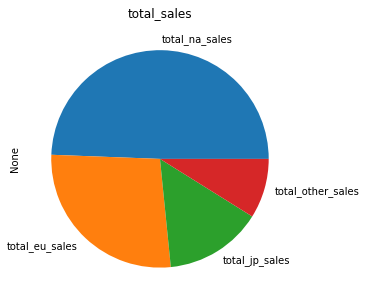

In [14]:
total_na_sales = games['na_sales'].sum()
total_eu_sales = games['eu_sales'].sum()
total_jp_sales = games['jp_sales'].sum()
total_other_sales = games['other_sales'].sum()
total = [total_na_sales, total_eu_sales, total_jp_sales, total_other_sales]
columns = ['total_na_sales', 'total_eu_sales', 'total_jp_sales', 'total_other_sales']
total_sales = pd.Series(total, columns)
total_sales.plot(grid=True,title='total_sales',figsize=(10,5),kind='pie')

We can see that the total sales of games in North America are roughly equal to the total sales worldwide, which shows the huge potential of this region.

# Exploratory data analysis

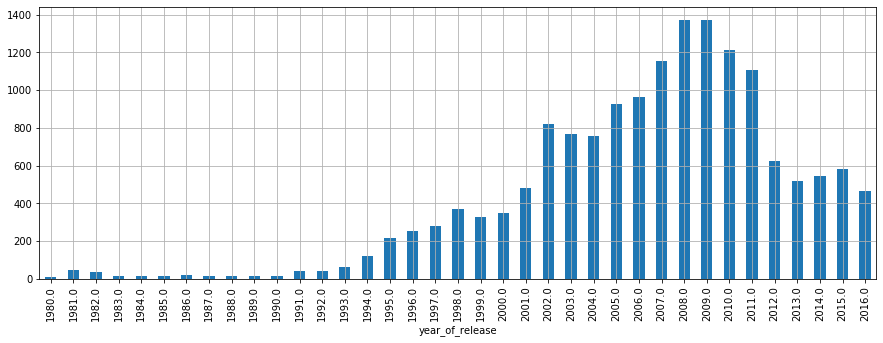

In [15]:
#how many games were released in different years
games_years = games.groupby('year_of_release')['name'].count()
games_years.plot(grid=True,figsize=(15,5),kind='bar')

Analyzing this graph, we see that from 1980 to 2001, game sales were at a very low level, followed by a decade of growth in sales and a subsequent sharp decline in 2012, followed by a declining trend.

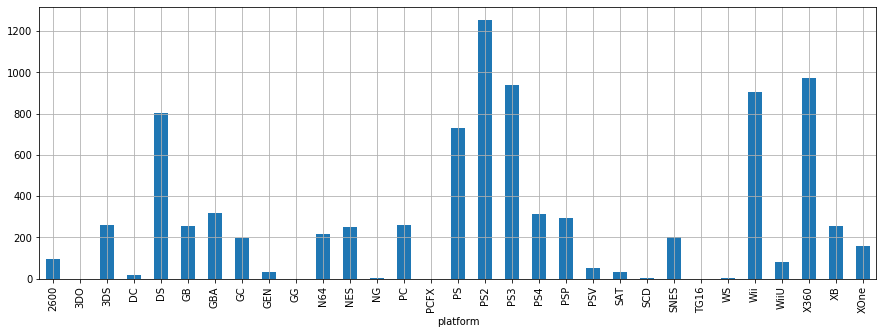

In [16]:
# change in sales by platform
total_platform = games.groupby('platform')['total_sales'].sum().plot(grid=True,figsize=(15,5),kind='bar')

We have six major platforms in a given time period(DS,PS,PS2,PS3,Wii,X360)

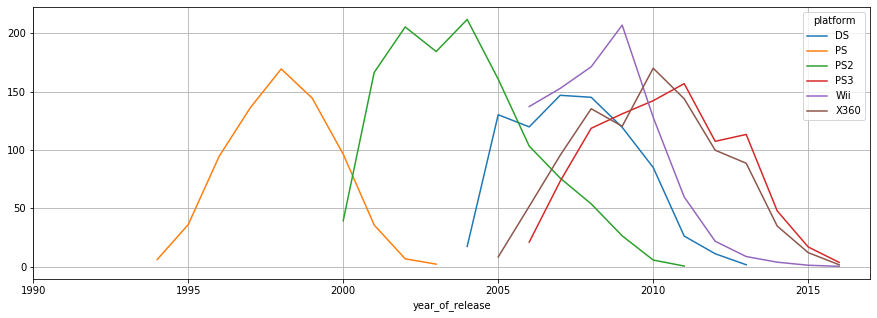

In [17]:
# platforms with the highest total sales and their distribution by year
popular_platform = games.query('platform == "DS" or platform == "PS" or platform == "PS2" or platform == "PS3" or platform == "Wii" or platform == "X360"')
popular_platform_year_income = popular_platform.pivot_table(index='year_of_release', columns="platform", values="total_sales", aggfunc=sum)
popular_platform_year_income.plot(grid=True,figsize=(15,5),xlim=(1990,2017))

                                                                                             

We see that the average platform life cycle is ten years. So it is interesting to look at the dynamics of PS platforms. So, the PS came out in late 1994 and dropped from sales in 2003. the PS2 came out in 2000, when PS sales were already on the decline. The PS3 came out in 2006 and the PS4 came out in 2013. Approximately every six years a new platform is released, which the previous version begins a steady decline in sales

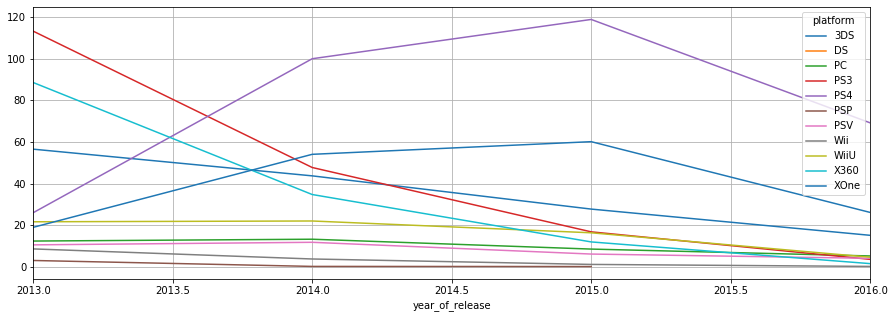

In [18]:
# table for the given current period from 2013 to 2016
actual_period = games.query('year_of_release >= 2013')
new_platforms_income = actual_period.pivot_table(index='year_of_release', columns="platform", values="total_sales", aggfunc=sum)
new_platforms_income.plot(grid=True,figsize=(15,5))

After analyzing the sales dynamics of the platforms and their life cycle, we see the growth of two new platforms since 2013 (PS4 and XOne). Since we need to do an analysis for 2017 and knowing that the platform life cycle is about ten years, we can assume that these two platforms can still have demand in the market. They are potentially profitable for us. It is less relevant to analyze the period before 2013, because the platforms we are interested in appeared only in 2013, and the others are in a phase of stable decline.

(0, 2)

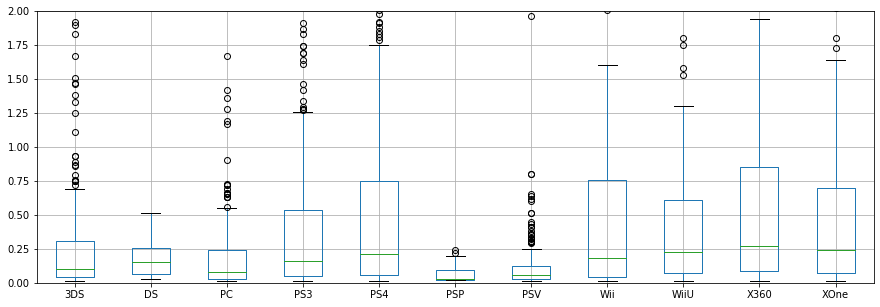

In [19]:
#A "mustache box" chart of global sales of each game and a breakdown by platform
games_total_sales = actual_period.pivot_table(index='name', columns='platform', values='total_sales', aggfunc=sum)
games_total_sales.boxplot(figsize=(15,5))
plt.ylim(0,2)

We see four leaders in sales of games on platforms (PS3,PS4,X360,XOne) with huge tails in terms of maximum value, while the PS and XBox platforms also have knock-out values, which indicates a large number of "bestselling" games for these platforms alone. That said, it's also worth noting the 3DS, which has a long maximum tail with average sales figures, which also speaks to exclusive games. The new generation platform of the Wii group (WiiU) is inferior to direct competitors in its niche (PS4 and XOne), despite the fact that the previous generation of the platform had a rather good competitive position.

              total_sales  critic_score  user_score
total_sales             1          0.41        0.03
critic_score         0.41             1        0.51
user_score           0.03          0.51           1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5d8e316a0>,
      dtype=object)

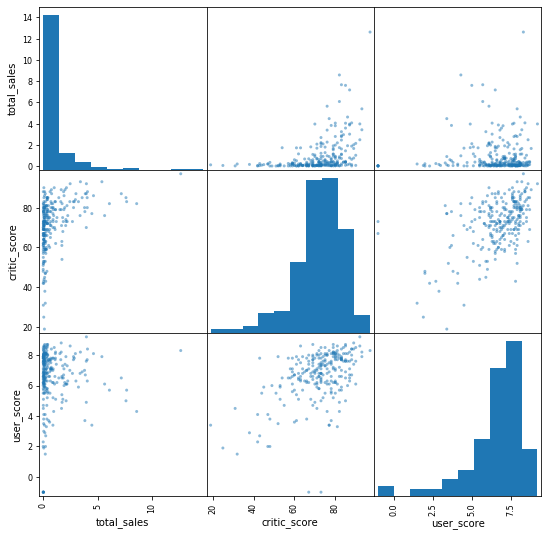

In [20]:
#diffusion diagram and correlation between reviews and sales for PS4
ps4 = actual_period.query('platform == "PS4"')
ps4 = ps4.loc[:,['total_sales', 'critic_score', 'user_score']]
print(ps4.corr())
pd.plotting.scatter_matrix(ps4, figsize=(9, 9))

              total_sales  critic_score  user_score
total_sales             1          0.42        0.09
critic_score         0.42             1        0.46
user_score           0.09          0.46           1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5d90669e8>,
      dtype=object)

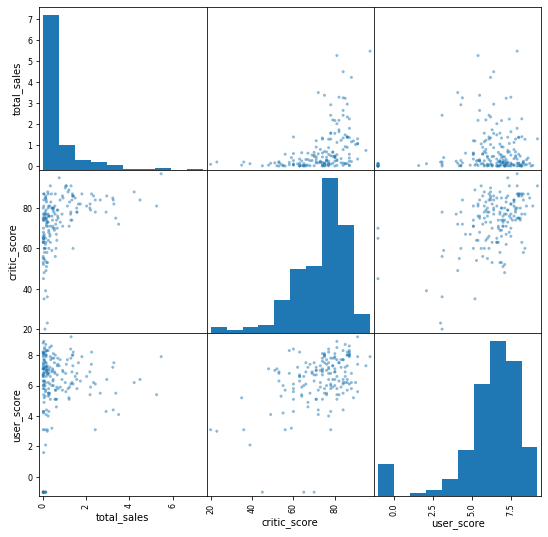

In [21]:
XOne = actual_period.query('platform == "XOne"')
XOne = XOne.loc[:,['total_sales', 'critic_score', 'user_score']]
print(XOne.corr())
pd.plotting.scatter_matrix(XOne, figsize=(9, 9))

For our two promising platforms we see the same correlation between scores and sales. So user ratings have no effect on sales (0.03 for PS4 and 0.09 for XOne). At the same time there is a small direct correlation between critics' scores and sales growth (0.41 and 0.42, respectively)

              total_sales  critic_score  user_score
total_sales             1          0.25        0.10
critic_score         0.25             1        0.49
user_score           0.10          0.49           1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5d39e3588>,
      dtype=object)

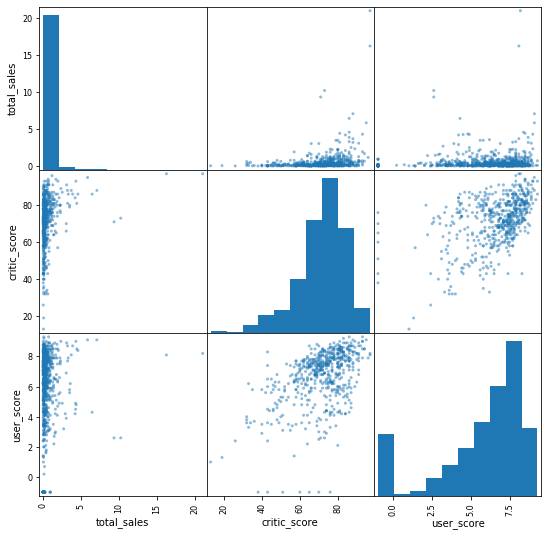

In [22]:
other_platforms = actual_period.query('platform != "PS4" and platform != "XOne"').loc[:,['total_sales', 'critic_score', 'user_score']]
print(other_platforms.corr())
pd.plotting.scatter_matrix(other_platforms, figsize=(9, 9))

For the other platforms as well, the critics' score does not significantly affect sales(0.25). And the correlation coefficient among user ratings is the same as for the main platforms(0.1), which also has no significant effect on sales.

In [23]:
# general distribution of games by genre
genres = actual_period.groupby('genre').agg(total_sales = pd.NamedAgg(column='total_sales', aggfunc=sum),
                                           games_amount = pd.NamedAgg(column='genre', aggfunc='count'))

genres['income_per_game'] = genres['total_sales']/genres['games_amount']
genres.sort_values(by='income_per_game', ascending=False)

,total_sales,games_amount,income_per_game
genre,,,
Shooter,232.96,185,1.26
Sports,150.62,211,0.71
Platform,42.62,73,0.58
Role-Playing,145.81,286,0.51
Racing,39.86,82,0.49
Action,321.38,719,0.45
Fighting,35.30,79,0.45
Misc,62.71,145,0.43
Simulation,21.72,58,0.37


The most profitable genre is the shooter. On average, one game brings in more than one million dollars ($1,260,000), which is noticeably ahead of other genres. In this case, the total sales in first place action (321.380.000 $), it is also in first place by the number of games in the genre (719). Number of action games in three and a half times more than going after category sports, indicating the great popularity of the genre, and not always successful games in it. At the same time in the category of sports good sales figure ($ 710,000).
Very low profit in adventure, strategy and puzzle games ($120,000 and $190,000 respectively), and very low total sales in the puzzle genre ($3,170,000)

# User portrait of each region

In [24]:
# Identify the most popular platforms (top 5) for users in each region (NA, EU, JP)
platforms_regions = actual_period.groupby('platform').agg(na_sales = pd.NamedAgg(column='na_sales', aggfunc=sum),
                                                          eu_sales = pd.NamedAgg(column='eu_sales', aggfunc=sum),
                                                          jp_sales = pd.NamedAgg(column='jp_sales', aggfunc=sum),
                                                     total_sales = pd.NamedAgg(column='total_sales', aggfunc=sum))
platforms_regions.sort_values(by='total_sales',ascending=False).head(5)

,na_sales,eu_sales,jp_sales,total_sales
platform,,,,
PS4,108.72,141.03,15.92,314.02
PS3,63.50,67.78,23.27,181.32
XOne,93.11,51.55,0.33,159.26
3DS,38.18,30.94,67.68,143.08
X360,81.65,42.5,0.50,136.76


The most popular platform in terms of sales is the PS4 ($ 314,020,000). It is also the best-selling platform in Europe and North America. In second place is the PS3, the total sales of which during the period under review amounted to $ 181,320,000. In this XOne (159.260.000 $ - total) in second place in sales in North America, while not sold in Japan, which can be explained by geographical affiliation of brands. These platforms are the most profitable in this period.
It is worth to pay attention to 3DS. Because of the specifics of the Japanese market this platform is the best-selling in this market (67.680.000$), ahead of almost 3 times going second PS3 (23.270.000$).

In [25]:
# Identify the most popular genres (top 5) for users in each region (NA, EU, JP)
genres_regions = actual_period.groupby('genre').agg(na_sales = pd.NamedAgg(column='na_sales', aggfunc=sum),
                                                          eu_sales = pd.NamedAgg(column='eu_sales', aggfunc=sum),
                                                          jp_sales = pd.NamedAgg(column='jp_sales', aggfunc=sum),
                                                     total_sales = pd.NamedAgg(column='total_sales', aggfunc=sum))
genres_regions.sort_values(by='total_sales',ascending=False).head(5)


,na_sales,eu_sales,jp_sales,total_sales
genre,,,,
Action,126.00,117.99,40.19,321.38
Shooter,109.74,87.85,6.60,232.96
Sports,65.26,60.50,5.41,150.62
Role-Playing,46.39,36.95,50.99,145.81
Misc,27.48,20.00,9.14,62.71


In [26]:
print(actual_period['jp_sales'].sum())

139.89


The most popular genre in terms of sales is action ($321,380,000). He is also the most popular in North America and Europe. Surely in second place is the shooter genre ($232,960,000). It is worth noting that the genres are identical in popularity among users in North America and Europe. 
In the Japanese market, role-playing is the most popular platform ($50,990,000). In second place is action($40,190,000). These two genres together account for 65% of the total Japanese genre market.

In [27]:
# the effect of the rating by region
rating_regions = actual_period.groupby('rating').agg(na_sales = pd.NamedAgg(column='na_sales', aggfunc=sum),
                                                          eu_sales = pd.NamedAgg(column='eu_sales', aggfunc=sum),
                                                          jp_sales = pd.NamedAgg(column='jp_sales', aggfunc=sum),
                                                     total_sales = pd.NamedAgg(column='total_sales', aggfunc=sum))
rating_regions.sort_values(by='total_sales',ascending=False)

,na_sales,eu_sales,jp_sales,total_sales
rating,,,,
M,165.21,145.32,14.11,371.68
E,79.05,83.36,15.14,200.16
T,49.79,41.95,20.59,126.62
E10+,54.24,42.69,5.89,115.39


Games with a rating of "M" ("Mature"). The materials of the game are not suitable for teenagers under the age of 17) are the most popular in the world ($371,680,000). These games are also the most popular in North America and Europe. In second place are games with a rating of "E" ("Everyone" - "For everyone" - the content is suitable for ages 6 years and older) - $ 200,160,000. In third place is a game with a rating of "T" (("Teen") - "To Teens": The game is suitable for persons 13 years and older) - $126,620,000.
As for the Japanese market, the most popular games are games with a rating of "T" ($20,590,000).

The portrait of the average user in North America and Europe in general is similar: - it is a user with the PS4 platform, who likes action or shooter games, with a rating of "M" (("Mature") - "For adults")
The Japanese average user likes less aggressive games with a rating of "T" (("Teen") - "Teenagers") in the role-playing genre and more often uses the 3DS platform.

# Hypothesis testing

# The null hypothesis: "The average user ratings of Xbox One and PC platforms are the same.

In [28]:
# select only PC platform and relevant user ratings
platform_PC = actual_period.query('platform == "PC" and user_score.notna()')
platform_PC_user_score = platform_PC.loc[:,['platform','user_score']]
print('Средний пользовательский рейтинг по платформе PC =',platform_PC['user_score'].mean())

Средний пользовательский рейтинг по платформе PC = 6.0425005


In [29]:
# select only XOne platform and relevant user ratings
platform_XOne = actual_period.query('platform == "XOne" and user_score.notna()')
platform_XOne_user_score = platform_XOne.loc[:,['platform','user_score']]
print('Средний пользовательский рейтинг по платформе XOne =',platform_XOne['user_score'].mean())

Средний пользовательский рейтинг по платформе XOne = 6.0927463


In [30]:
# let's set the commonly used threshold value of 5%
alpha = .05
# use the method st.ttest_ind to test the hypothesis
results = st.ttest_ind(platform_PC_user_score['user_score'], platform_XOne_user_score['user_score'])
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8288085383549834
Не получилось отвергнуть нулевую гипотезу


We formed the null hypothesis: "The average user ratings of Xbox One and PC platforms are the same. Then the alternative hypothesis is "The average user ratings of Xbox One and PC platforms are different. Let's set the commonly accepted threshold value at 5%. As we see the p-value is 0.83, which does not reject our null hypothesis. We accept in this case the null hypothesis that the average user ratings of the Xbox One and PC platforms are the same.

# Null hypothesis: "The average user ratings for the Action and Sports genres are the same.

In [31]:
# select only action genre and relevant user ratings
genre_action = actual_period.query('genre == "Action" and user_score.notna()')
genre_action_user_score = genre_action.loc[:,['genre','user_score']]
print('Средний пользовательский рейтинг в жанре action =',genre_action['user_score'].mean())

Средний пользовательский рейтинг в жанре action = 6.0574074


In [32]:
# choose only the genre of sports and relevant user ratings
genre_sports = actual_period.query('genre == "Sports" and user_score.notna()')
genre_sports_user_score = genre_sports.loc[:,['genre','user_score']]
print('Средний пользовательский рейтинг в жанре sports =',genre_sports['user_score'].mean())

Средний пользовательский рейтинг в жанре sports = 4.769364


In [33]:
# let's set the commonly used threshold value of 5%
alpha = .05
# use the method st.ttest_ind to test the hypothesis
results = st.ttest_ind(genre_action_user_score['user_score'], genre_sports_user_score['user_score'])
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.729302428591464e-08
Отвергаем нулевую гипотезу


We formed the null hypothesis: "Average user ratings of Action and Sports genres are the same. Then the alternative hypothesis would be: "Average user ratings of Action and Sports genres are different". Let's set the commonly accepted threshold value at 5%. As we see the p-value is 4.73, which rejects our null hypothesis. We accept the alternative hypothesis in this case, the average user ratings of action and sports genres are different.

# General Conclusion

When making sales forecast for 2017 we should pay attention to such important factors when forecasting sales:
- By analyzing the sales dynamics of the platforms and their life cycle, we have seen the growth of two new platforms since 2013(PS4 and XOne). Since we need to do an analysis for 2017 and knowing that the platform life cycle is about ten years, we can assume that these two platforms can still have demand in the market. They are potentially profitable for us. Also from 2010 to 2016 we see still continued demand for previous generations of platforms and one "specific" platform(3DS). 
- We see four leaders in game sales on platforms(PS3,PS4,X360,XOne) with huge tails in terms of maximum value, with the PS and XBOX platforms also having knock-out values, which indicates more "bestselling" games for those platforms alone. That said, it's also worth noting the 3DS, which has a long maximum tail with average sales figures, which also speaks to exclusive games. The next-generation platform of the Wii group (WiiU) is inferior to direct competitors in its niche (PS4 and XOne), despite the fact that the previous generation of the platform had a rather good competitive position.
- For our two promising platforms, we see the same correlation between scores and sales. So user score has no effect on sales (0.03 for PS4 and 0.09 for XOne). At the same time there is a slight direct correlation between critics' scores and sales growth (0.41 and 0.42 respectively).
- The most profitable genre is the shooter. At the same time in terms of total sales action is in first place, it is also in first place by the number of games in the genre. The number of action games is three and a half times more than the following sports category, which indicates the great popularity of the genre, and not always successful games in it. At the same time in the category of sports is a good indicator of sales. Very low profits in adventure, strategy and puzzle genres, and very low total sales in puzzle genre.
- The portrait of the average user in North America and Europe is generally similar: it is a PS4 user who likes action or shooter games, with a rating of "M" ("Mature"). The Japanese average user likes less aggressive games with a rating of "T"(("Teen")) in the role-playing genre and uses the 3DS platform more often.
- According to our formulated null hypothesis: "The average user ratings of Xbox One and PC platforms are the same.
- According to our alternative hypothesis: "The average user ratings of the action and sports genres are different.